<a href="https://colab.research.google.com/github/jamesBaker361/colab/blob/master/trasnfermultiple.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
# pytorch imports
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
import torchvision.transforms.functional as tF
import torchvision.models as models

# visualization tools
from PIL import Image,ImageOps
import matplotlib.pyplot as plt
plt.ion()

# misc
import numpy as np
import os
import copy
from urllib.request import urlretrieve
from google.colab import files

In [0]:
# specify whether pytorch uses cpu or gpu
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# desired size of the output image
imsize = 512

In [0]:
def imload(image_name, imsize,content=True):
    image = Image.open(image_name)        # read the image into an array
    if content==True:
      horiz=0
      vert=0
      if image.width < imsize or image.height <imsize:
        if image.height >image.width:
          horiz=int((image.height-image.width)/2)
        else:
          vert=int((image.width-image.height)/2)
      image=ImageOps.expand(image,border=(horiz,vert),fill="white")
    image = tF.resize(image, imsize)      # resize the image and casts it to a tensor
    image = tF.center_crop(image, imsize) # center crop to size
    image = tF.to_tensor(image)           # cast PIL image to pytorch tensor
    image = image.float()                 # cast to float tensor
    image = image.unsqueeze(0)            # insert dummy batch dimension needed to fit into the model
    
    return image
  
# unload a tensor into a PIL image
imunload = torchvision.transforms.ToPILImage()

# displays an image from a tensor
def imshow(tensor, title=None):
    image = tensor.cpu().clone() # clone the tensor to not do changes on it
    image = image.squeeze(0)     # remove the fake batch dimension
    image = imunload(image)      # unload the image into PIL
    
    # matplotlib: show the image
    plt.imshow(image)
    plt.grid(False)
    if title is not None:
        plt.title(title)
    plt.show()
    return

In [0]:
def urlsToTensors(urls,content=True):
  cont=[]
  for u in urls:
    print(u)
    _ = urlretrieve(u,'img.jpg')
    cont.append(imload("./img.jpg", imsize,content).to(device))
  return(cont)

def urlToTensor(url,content=True):
  _=urlretrieve(url,'img.jpg')
  return(imload("./img.jpg", imsize,content).to(device))

In [0]:
# set loss weights
content_weight = 1
style_weight = 100000

# set number of steps
# 16 steps take around 60s
steps = 32

In [0]:
# get gram matrix of feature block
def gram_matrix(x):
    # flatten spatial features
    bs, nfeats, h, w = x.size()
    x = x.view(bs*nfeats, h*w)
    
    # compute gram product by matrix multiplication and normalize
    G = torch.mm(x, x.t())
    G.div(bs*nfeats*h*w)
    return G

In [0]:
# default vgg normalization values
vgg_norm_mean = torch.tensor([0.485, 0.456, 0.406]).view(-1, 1, 1)
vgg_norm_std = torch.tensor([0.229, 0.224, 0.225]).view(-1, 1, 1)

# extract features from input at layers of interest
class VGGFeatureExtractor(nn.Module):
    
    # given a vgg model, makes a copy of the vgg with only the
    # layers required to extract features at layers of interest;
    def __init__(self, vgg, layers_of_interest):
        super(VGGFeatureExtractor, self).__init__()
        
        # remember layers of interest
        self.layers_of_interest = layers_of_interest
        
        # copy vgg into a list
        # keep only up to the max layer of interest
        self.layer_list = []
        for i in range(max(layers_of_interest)+1):
            
            # replace relu layers with not in-place relu layers
            if isinstance(vgg[i], nn.ReLU):
                self.layer_list.append(nn.ReLU(inplace=False))
            
            # otherwise, just append a copy of the layer
            else:
                self.layer_list.append(copy.deepcopy(vgg[i]))
        
        # layer_list should now be just the subset of vgg
        # you need to extract features at layers of interest
        return
    
    # feed the input through the layers, remembering
    # the outputs of layers of interest
    def forward(self, x):
        
        # normalize the input
        x = (x - vgg_norm_mean.to(x.device)) / vgg_norm_std.to(x.device)
        
        # feed the input through layer by layer, while keeping
        # a list of features extracted at layers of interest
        extracted_features = {}
        for i in range(max(self.layers_of_interest)+1):
            
            # apply the layer to the previous output
            layer = self.layer_list[i]
            x = layer(x)
            
            # remember the output if the layer was of interest
            if i in self.layers_of_interest:
                extracted_features[i] = x
        
        # extracted_features should now have all features of interest
        return extracted_features

In [8]:
# get a copy of the pretrained vgg image classification model
vgg = models.vgg19(pretrained=True).features.to(device).eval()
#print(vgg)

Downloading: "https://download.pytorch.org/models/vgg19-dcbb9e9d.pth" to /root/.torch/models/vgg19-dcbb9e9d.pth
574673361it [00:06, 89267433.22it/s]


In [0]:
# we will select the following layers to use
content_layers = set([7])
style_layers = set([0,2,5,7,10])

In [0]:
# construct network, set it to evaluation mode
model = VGGFeatureExtractor(
    vgg,
    layers_of_interest=set.union(content_layers, style_layers),
).to(device).eval()

# vgg is no longer needed
del vgg

In [0]:
# get features for style image
# convert features into gram matrices
def styleImgToFeat(style_img): #style_img is a tensor of an image
  style_features = model(style_img)
  for i in style_features:
      style_features[i] = gram_matrix(style_features[i])
  style_features = {i:style_features[i].detach() for i in style_features}
  return style_features

def contImgToFeat(content_img): #also an image tensor
  content_features = model(content_img)
  content_features = {i:content_features[i].detach() for i in content_features}
  return content_features

def getx(content_img):
  x = content_img.clone()
  #imshow(x, title='x (input image)')
  # set x so that it takes gradient updates
  x.requires_grad_()
  optimizer = optim.LBFGS([x])
  return x,optimizer

In [0]:
def transfer(style_img,content_img):
  content_features=contImgToFeat(content_img)
  style_features=styleImgToFeat(style_img)
  x,optimizer=getx(content_img)
  # apply style for many steps
  for n in range(steps):

      # fancy gradient update procedure for lbfgs
      def closure():
          # clear gradients
          optimizer.zero_grad()

          # get features of x
          x_features = model(x)

          # calculate content loss
          content_loss = 0
          for i in content_layers:
              content_loss += F.mse_loss(
                  x_features[i],
                  content_features[i],
              )

          # calculate style loss
          style_loss = 0
          for i in style_layers:
              style_loss += F.mse_loss(
                  gram_matrix(x_features[i]),
                  style_features[i],
              )

          # calculate total loss, and backpropagate
          loss = content_loss*content_weight + style_loss*style_weight
          loss.backward(retain_graph=True)
          del x_features
          # return loss
          return loss
      optimizer.step(closure)

      # clamp image values
      x.data.clamp_(0,1)

      # print updates
      if n%4==0:
          print('step: %d / %d'%(n,steps))

  # print completion
  print('%d steps complete'%steps)
  #imshow(content_img, title='content image')
  #imshow(style_img, title='style image')
  imshow(x, title='style-transfered image')
  del content_img,content_features,style_img,style_features,optimizer
  return(x)

In [0]:
def transferMultiStyle(styleList,content_img,steps=steps):
  content_features=contImgToFeat(content_img)
  styles=[]
  for s in styleList:
    styles.append(styleImgToFeat(s))
  x,optimizer=getx(content_img)
  # apply style for many steps
  for n in range(steps):

      # fancy gradient update procedure for lbfgs
      def closure():
          # clear gradients
          optimizer.zero_grad()

          # get features of x
          x_features = model(x)

          # calculate content loss
          content_loss = 0
          for i in content_layers:
              content_loss += F.mse_loss(
                  x_features[i],
                  content_features[i],
              )

          # calculate style loss
          style_loss = 0
          for i in style_layers:
            for style_features in styles:
                style_loss += F.mse_loss(
                    gram_matrix(x_features[i]),
                    style_features[i],
                )

          # calculate total loss, and backpropagate
          loss = content_loss*content_weight + style_loss*style_weight
          loss.backward(retain_graph=True)
          del x_features
          # return loss
          return loss
      optimizer.step(closure)

      # clamp image values
      x.data.clamp_(0,1)

      # print updates
      if n%1==0:
          print('step: %d / %d'%(n,steps))
          imshow(x)

  # print completion
  print('%d steps complete'%steps)
  #imshow(content_img, title='content image')
  #imshow(style_img, title='style image')
  imshow(x, title='style-transfered image')
  for s in styles:
    del s
  del content_img,content_features,optimizer, styles
  return(x)

In [0]:
styleURLS=['https://images.graph.cool/v1/cj6c28vh912680101ozc2paxj/cjf2y07bi0xkc0140u26s5sh3/0x56:768x403/1200x630/picasso_lesfemmesdalger_low.jpg']
contentURLS=['https://i.ytimg.com/vi/Wip3TEZjL-I/hqdefault.jpg']

https://images.graph.cool/v1/cj6c28vh912680101ozc2paxj/cjf2y07bi0xkc0140u26s5sh3/0x56:768x403/1200x630/picasso_lesfemmesdalger_low.jpg
https://i.ytimg.com/vi/Wip3TEZjL-I/hqdefault.jpg


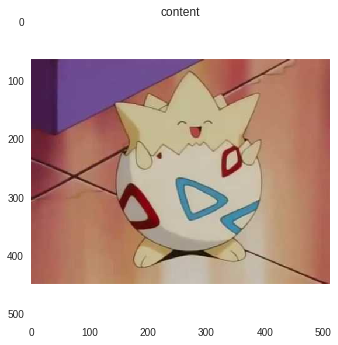

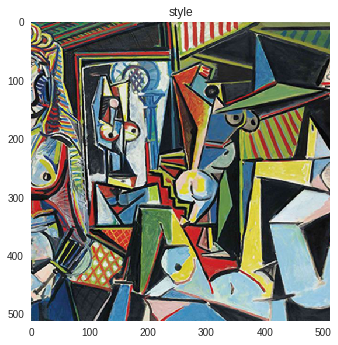

step: 0 / 32
step: 4 / 32
step: 8 / 32
step: 12 / 32
step: 16 / 32
step: 20 / 32
step: 24 / 32
step: 28 / 32
32 steps complete


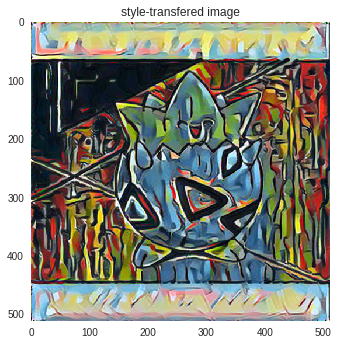

In [15]:
styles=urlsToTensors(styleURLS,False)
contents=urlsToTensors(contentURLS)
for s in styles:
  for c in contents:
    imshow(c,title="content")
    imshow(s,title="style")
    x=transfer(s,c)

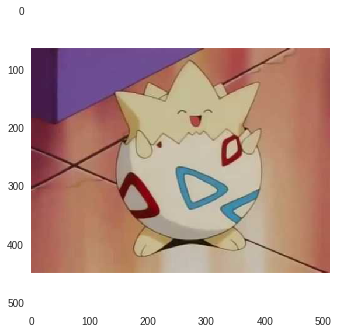

In [16]:
togepi=contents[0]
imshow(togepi)

In [17]:
fujiURLS=['https://upload.wikimedia.org/wikipedia/commons/thumb/7/73/Shichiri_beach_in_Sagami_province.jpg/150px-Shichiri_beach_in_Sagami_province.jpg','https://upload.wikimedia.org/wikipedia/commons/thumb/9/94/Umegawa_in_Sagami_province.jpg/150px-Umegawa_in_Sagami_province.jpg','https://upload.wikimedia.org/wikipedia/commons/thumb/2/2b/Lake_Suwa_in_the_Shinano_province.jpg/150px-Lake_Suwa_in_the_Shinano_province.jpg','https://upload.wikimedia.org/wikipedia/commons/thumb/d/d4/A_sketch_of_the_Mitsui_shop_in_Suruga_street_in_Edo.jpg/150px-A_sketch_of_the_Mitsui_shop_in_Suruga_street_in_Edo.jpg']
fujiStyle=urlsToTensors(fujiURLS,False)

https://upload.wikimedia.org/wikipedia/commons/thumb/7/73/Shichiri_beach_in_Sagami_province.jpg/150px-Shichiri_beach_in_Sagami_province.jpg
https://upload.wikimedia.org/wikipedia/commons/thumb/9/94/Umegawa_in_Sagami_province.jpg/150px-Umegawa_in_Sagami_province.jpg
https://upload.wikimedia.org/wikipedia/commons/thumb/2/2b/Lake_Suwa_in_the_Shinano_province.jpg/150px-Lake_Suwa_in_the_Shinano_province.jpg
https://upload.wikimedia.org/wikipedia/commons/thumb/d/d4/A_sketch_of_the_Mitsui_shop_in_Suruga_street_in_Edo.jpg/150px-A_sketch_of_the_Mitsui_shop_in_Suruga_street_in_Edo.jpg


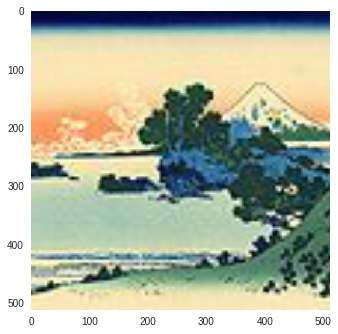

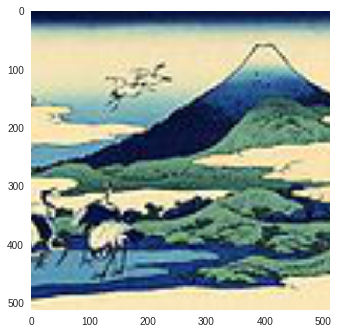

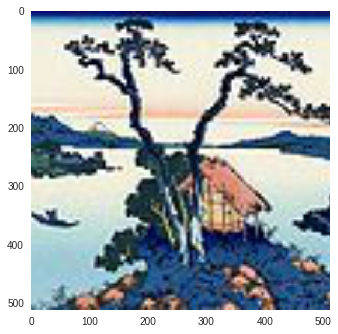

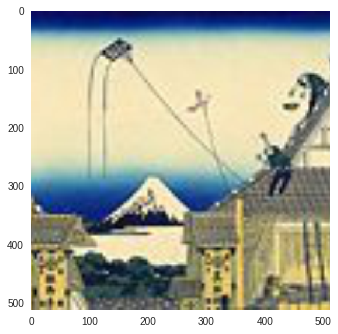

In [18]:
for f in fujiStyle:
  imshow(f)

step: 0 / 32
step: 1 / 32
step: 2 / 32
step: 3 / 32
step: 4 / 32
step: 5 / 32
step: 6 / 32
step: 7 / 32
step: 8 / 32
step: 9 / 32
step: 10 / 32
step: 11 / 32
step: 12 / 32
step: 13 / 32
step: 14 / 32
step: 15 / 32
step: 16 / 32
step: 17 / 32
step: 18 / 32
step: 19 / 32
step: 20 / 32
step: 21 / 32
step: 22 / 32
step: 23 / 32
step: 24 / 32
step: 25 / 32
step: 26 / 32
step: 27 / 32
step: 28 / 32
step: 29 / 32
step: 30 / 32
step: 31 / 32
32 steps complete


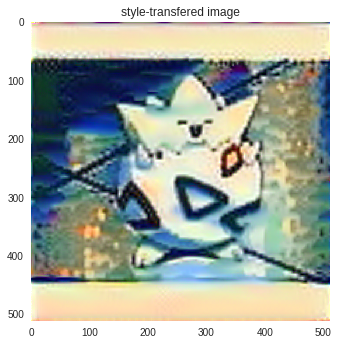

tensor([[[[1.0000, 1.0000, 1.0000,  ..., 0.2435, 0.2944, 0.2743],
          [1.0000, 1.0000, 1.0000,  ..., 0.3833, 0.5297, 0.4110],
          [1.0000, 1.0000, 0.9534,  ..., 0.5877, 0.6892, 0.4959],
          ...,
          [1.0000, 1.0000, 1.0000,  ..., 1.0000, 0.9388, 1.0000],
          [1.0000, 0.9464, 1.0000,  ..., 0.7947, 0.7496, 0.8712],
          [1.0000, 0.9859, 1.0000,  ..., 0.9813, 0.9786, 1.0000]],

         [[0.9812, 1.0000, 1.0000,  ..., 0.3700, 0.3244, 0.2743],
          [1.0000, 0.9774, 0.9054,  ..., 0.5930, 0.5942, 0.4974],
          [0.8939, 0.6713, 0.6698,  ..., 0.5763, 0.6332, 0.6227],
          ...,
          [1.0000, 0.9414, 0.9173,  ..., 0.7762, 0.8250, 0.7871],
          [1.0000, 0.8924, 0.8495,  ..., 0.8247, 0.8778, 0.7629],
          [1.0000, 0.8722, 0.8015,  ..., 0.5916, 0.5536, 0.5766]],

         [[0.4871, 0.4743, 0.3551,  ..., 0.4415, 0.4195, 0.6805],
          [0.4593, 0.0000, 0.2101,  ..., 0.4489, 0.3185, 0.6449],
          [0.7881, 0.8707, 1.0000,  ..., 0

In [19]:
transferMultiStyle(fujiStyle,togepi)

In [0]:
mountain=urlToTensor('https://img.purch.com/w/660/aHR0cDovL3d3dy5saXZlc2NpZW5jZS5jb20vaW1hZ2VzL2kvMDAwLzA5OC81NzYvb3JpZ2luYWwvZGVuYWxpLXRvbnMtb2YtcG9vcC5qcGc=')

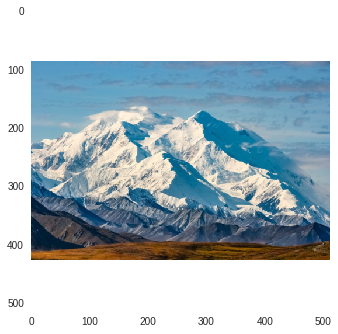

In [21]:
imshow(mountain)

step: 0 / 32
step: 1 / 32
step: 2 / 32
step: 3 / 32
step: 4 / 32
step: 5 / 32
step: 6 / 32
step: 7 / 32
step: 8 / 32
step: 9 / 32
step: 10 / 32
step: 11 / 32
step: 12 / 32
step: 13 / 32
step: 14 / 32
step: 15 / 32
step: 16 / 32
step: 17 / 32
step: 18 / 32
step: 19 / 32
step: 20 / 32
step: 21 / 32
step: 22 / 32
step: 23 / 32
step: 24 / 32
step: 25 / 32
step: 26 / 32
step: 27 / 32
step: 28 / 32
step: 29 / 32
step: 30 / 32
step: 31 / 32
32 steps complete


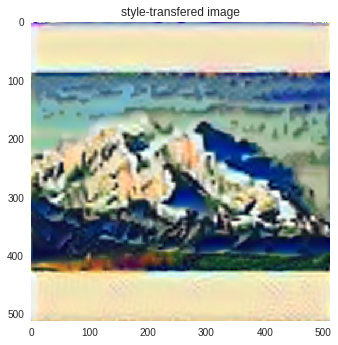

tensor([[[[1.0000, 1.0000, 1.0000,  ..., 1.0000, 1.0000, 1.0000],
          [1.0000, 0.9988, 0.9142,  ..., 0.8912, 1.0000, 1.0000],
          [0.6364, 0.5450, 0.5555,  ..., 0.7969, 0.8354, 0.8809],
          ...,
          [0.9794, 0.9020, 0.8720,  ..., 0.9162, 0.8510, 0.9062],
          [1.0000, 0.9010, 0.9417,  ..., 0.8242, 0.8706, 0.8329],
          [0.9848, 0.8458, 0.8847,  ..., 0.7991, 0.7497, 0.7339]],

         [[1.0000, 1.0000, 1.0000,  ..., 1.0000, 1.0000, 1.0000],
          [0.4324, 0.1570, 0.2616,  ..., 0.9290, 0.9241, 0.8599],
          [0.4318, 0.5636, 0.5119,  ..., 0.7128, 0.7166, 0.8206],
          ...,
          [0.7953, 0.8802, 0.9517,  ..., 0.8276, 0.8921, 0.8560],
          [0.7527, 0.7848, 0.8173,  ..., 0.8222, 0.8738, 0.8054],
          [0.6981, 0.8140, 0.8357,  ..., 0.7789, 0.7679, 0.7523]],

         [[0.8258, 0.5220, 0.6783,  ..., 0.7031, 0.3225, 0.3570],
          [0.7587, 0.8345, 1.0000,  ..., 0.3682, 0.3572, 0.5082],
          [1.0000, 1.0000, 0.9719,  ..., 0

In [22]:
transferMultiStyle(fujiStyle,mountain)

step: 0 / 4
step: 1 / 4
step: 2 / 4
step: 3 / 4
4 steps complete


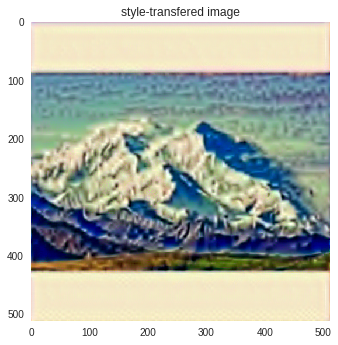

tensor([[[[0.9032, 0.7947, 0.8119,  ..., 0.8980, 0.9178, 0.9482],
          [0.8532, 0.8315, 0.8300,  ..., 0.8753, 0.8794, 0.9028],
          [0.9138, 0.8200, 0.8505,  ..., 0.9219, 0.8998, 0.9561],
          ...,
          [0.9844, 0.9340, 1.0000,  ..., 0.9327, 0.8716, 0.9148],
          [0.9665, 0.9361, 0.9517,  ..., 0.8525, 0.8147, 0.8630],
          [1.0000, 0.9978, 0.9896,  ..., 0.8942, 0.8708, 0.8754]],

         [[0.7898, 0.6932, 0.7119,  ..., 0.7968, 0.7907, 0.7561],
          [0.6894, 0.7566, 0.7719,  ..., 0.8438, 0.8449, 0.7353],
          [0.8133, 0.8079, 0.8197,  ..., 0.8390, 0.8627, 0.8138],
          ...,
          [0.8458, 0.9259, 0.9205,  ..., 0.8418, 0.8524, 0.7735],
          [0.8218, 0.9486, 0.9415,  ..., 0.8751, 0.8582, 0.7726],
          [0.8475, 0.9348, 0.9434,  ..., 0.8171, 0.8071, 0.7709]],

         [[0.8680, 0.8460, 0.8584,  ..., 0.7971, 0.7474, 0.7051],
          [0.7584, 0.8374, 0.7971,  ..., 0.7494, 0.7158, 0.6191],
          [0.8601, 0.9044, 0.8569,  ..., 0

In [24]:
transferMultiStyle(fujiStyle,mountain,steps=4)

step: 0 / 8
step: 1 / 8
step: 2 / 8
step: 3 / 8
step: 4 / 8
step: 5 / 8
step: 6 / 8
step: 7 / 8
8 steps complete


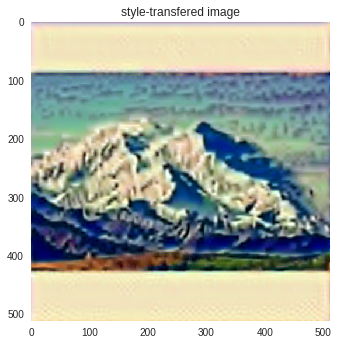

tensor([[[[0.8491, 0.7306, 0.7273,  ..., 0.8562, 0.8649, 0.9003],
          [0.7782, 0.7639, 0.7654,  ..., 0.7439, 0.7263, 0.8366],
          [0.8825, 0.7900, 0.8259,  ..., 0.8921, 0.7933, 0.8860],
          ...,
          [1.0000, 0.9801, 1.0000,  ..., 0.9588, 0.8441, 0.8906],
          [1.0000, 0.9734, 0.9863,  ..., 0.8293, 0.7714, 0.8467],
          [1.0000, 1.0000, 1.0000,  ..., 0.9192, 0.8624, 0.8801]],

         [[0.7164, 0.6112, 0.6213,  ..., 0.8707, 0.8039, 0.7169],
          [0.5626, 0.6424, 0.6730,  ..., 0.8088, 0.8037, 0.7441],
          [0.7668, 0.7673, 0.7625,  ..., 0.7935, 0.8242, 0.8338],
          ...,
          [0.8822, 0.9322, 0.9225,  ..., 0.8204, 0.8454, 0.7860],
          [0.8458, 0.9549, 0.9309,  ..., 0.8687, 0.8748, 0.8151],
          [0.8703, 0.9005, 0.9103,  ..., 0.8218, 0.8178, 0.7977]],

         [[0.8385, 0.8036, 0.7950,  ..., 0.7516, 0.6772, 0.6265],
          [0.6988, 0.7832, 0.7232,  ..., 0.6167, 0.6111, 0.5736],
          [0.8716, 0.9198, 0.8483,  ..., 0

In [25]:
transferMultiStyle(fujiStyle,mountain,steps=8)

In [0]:
baroque=[imload("baroque1.jpg", imsize).to(device),imload("baroque2.jpg", imsize).to(device),imload("baroque3.jpg", imsize).to(device)]

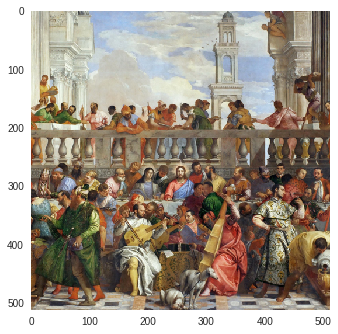

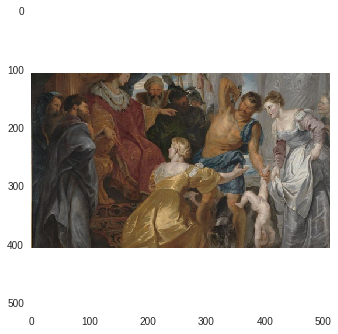

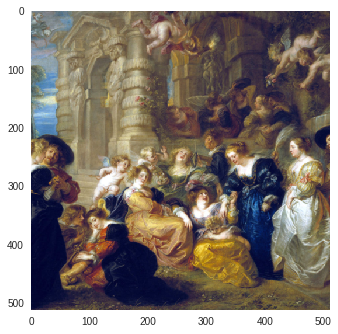

In [41]:
for b in baroque:
  imshow(b)

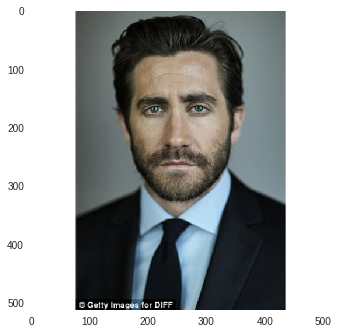

In [44]:
jake=imload("jake.jpg", imsize).to(device)
imshow(jake)

step: 0 / 16
step: 1 / 16
step: 2 / 16
step: 3 / 16
step: 4 / 16
step: 5 / 16
step: 6 / 16
step: 7 / 16
step: 8 / 16
step: 9 / 16
step: 10 / 16
step: 11 / 16
step: 12 / 16
step: 13 / 16
step: 14 / 16
step: 15 / 16
16 steps complete


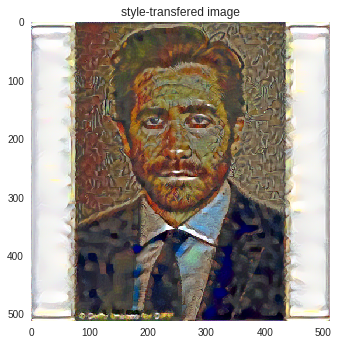

tensor([[[[0.6874, 0.6829, 0.8282,  ..., 0.9787, 0.9213, 0.8635],
          [0.7024, 0.8891, 0.9219,  ..., 0.9793, 0.9520, 0.9359],
          [0.8660, 1.0000, 0.9303,  ..., 0.9905, 1.0000, 0.8105],
          ...,
          [0.6518, 0.9666, 1.0000,  ..., 0.9434, 0.8897, 0.7904],
          [0.6473, 0.9362, 0.9431,  ..., 0.7875, 0.6872, 0.6484],
          [0.5924, 0.7960, 0.9490,  ..., 0.7464, 0.6807, 0.5870]],

         [[0.6382, 0.5907, 0.8485,  ..., 1.0000, 1.0000, 0.8241],
          [0.7987, 0.8358, 0.8949,  ..., 1.0000, 1.0000, 0.8911],
          [0.8161, 0.9258, 0.9617,  ..., 1.0000, 1.0000, 0.8324],
          ...,
          [0.5134, 0.7906, 0.9656,  ..., 0.9715, 0.8798, 0.6959],
          [0.5625, 0.8298, 0.9037,  ..., 0.9211, 0.8012, 0.6195],
          [0.4678, 0.5822, 0.8216,  ..., 0.7670, 0.6787, 0.4776]],

         [[0.8549, 0.6866, 0.6403,  ..., 0.8955, 0.7555, 0.6799],
          [1.0000, 0.9977, 0.9986,  ..., 1.0000, 0.9958, 0.8526],
          [0.8646, 0.9784, 0.9275,  ..., 0

In [46]:
transferMultiStyle(baroque,jake,steps=16)

step: 0 / 32
step: 1 / 32
step: 2 / 32
step: 3 / 32
step: 4 / 32
step: 5 / 32
step: 6 / 32
step: 7 / 32
step: 8 / 32
step: 9 / 32
step: 10 / 32
step: 11 / 32
step: 12 / 32
step: 13 / 32
step: 14 / 32
step: 15 / 32
step: 16 / 32
step: 17 / 32
step: 18 / 32
step: 19 / 32
step: 20 / 32
step: 21 / 32
step: 22 / 32
step: 23 / 32
step: 24 / 32
step: 25 / 32
step: 26 / 32
step: 27 / 32
step: 28 / 32
step: 29 / 32
step: 30 / 32
step: 31 / 32
32 steps complete


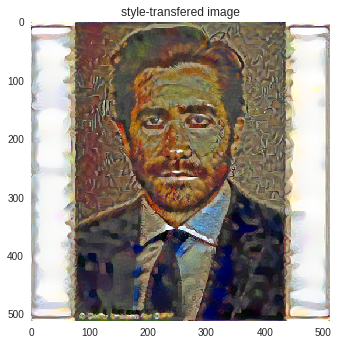

tensor([[[[0.6482, 0.9274, 0.9518,  ..., 1.0000, 1.0000, 0.9860],
          [0.8657, 1.0000, 0.9331,  ..., 1.0000, 1.0000, 1.0000],
          [1.0000, 1.0000, 0.9506,  ..., 1.0000, 1.0000, 1.0000],
          ...,
          [0.7926, 1.0000, 1.0000,  ..., 1.0000, 0.8423, 0.9045],
          [0.8920, 1.0000, 0.9328,  ..., 0.7534, 0.6798, 0.6871],
          [0.7072, 0.7943, 0.8028,  ..., 0.7360, 0.6061, 0.6237]],

         [[0.6442, 0.8735, 1.0000,  ..., 1.0000, 1.0000, 1.0000],
          [0.9914, 0.9819, 0.9427,  ..., 1.0000, 1.0000, 1.0000],
          [1.0000, 1.0000, 1.0000,  ..., 1.0000, 1.0000, 1.0000],
          ...,
          [0.7647, 0.8669, 0.8967,  ..., 0.9160, 0.7957, 0.8673],
          [0.8656, 0.9188, 0.9017,  ..., 0.8555, 0.7860, 0.7234],
          [0.6411, 0.6498, 0.7634,  ..., 0.8181, 0.6631, 0.6021]],

         [[0.7930, 0.7487, 0.7164,  ..., 0.9606, 0.9443, 0.7225],
          [1.0000, 1.0000, 1.0000,  ..., 1.0000, 1.0000, 1.0000],
          [0.9808, 0.9182, 0.8887,  ..., 0

In [47]:
transferMultiStyle(baroque,jake,steps=32)

In [0]:
def transferMultiMemory(styleList,content_img,steps=steps,lastImg=content_img):
  content_features=contImgToFeat(content_img)
  styles=[]
  for s in styleList:
    styles.append(styleImgToFeat(s))
  x,optimizer=getx(lastImg)
  # apply style for many steps
  for n in range(steps):

      # fancy gradient update procedure for lbfgs
      def closure():
          # clear gradients
          optimizer.zero_grad()

          # get features of x
          x_features = model(x)

          # calculate content loss
          content_loss = 0
          for i in content_layers:
              content_loss += F.mse_loss(
                  x_features[i],
                  content_features[i],
              )

          # calculate style loss
          style_loss = 0
          for i in style_layers:
            for style_features in styles:
                style_loss += F.mse_loss(
                    gram_matrix(x_features[i]),
                    style_features[i],
                )

          # calculate total loss, and backpropagate
          loss = content_loss*content_weight + style_loss*style_weight
          loss.backward(retain_graph=True)
          del x_features
          # return loss
          return loss
      optimizer.step(closure)

      # clamp image values
      x.data.clamp_(0,1)

      # print updates
      if n%1==0:
          print('step: %d / %d'%(n,steps))
          imshow(x)

  # print completion
  print('%d steps complete'%steps)
  #imshow(content_img, title='content image')
  #imshow(style_img, title='style image')
  imshow(x, title='style-transfered image')
  for s in styles:
    del s
  del content_img,content_features,optimizer, styles
  return(x)

step: 0 / 12
step: 1 / 12
step: 2 / 12
step: 3 / 12
step: 4 / 12
step: 5 / 12
step: 6 / 12
step: 7 / 12
step: 8 / 12
step: 9 / 12
step: 10 / 12
step: 11 / 12
12 steps complete


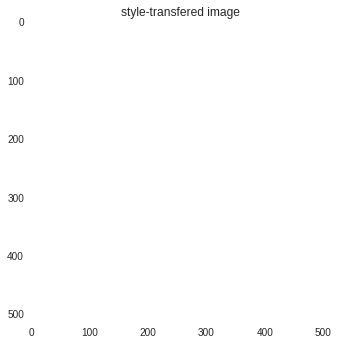

tensor([[[[1., 1., 1.,  ..., 1., 1., 1.],
          [1., 1., 1.,  ..., 1., 1., 1.],
          [1., 1., 1.,  ..., 1., 1., 1.],
          ...,
          [1., 1., 1.,  ..., 1., 1., 1.],
          [1., 1., 1.,  ..., 1., 1., 1.],
          [1., 1., 1.,  ..., 1., 1., 1.]],

         [[1., 1., 1.,  ..., 1., 1., 1.],
          [1., 1., 1.,  ..., 1., 1., 1.],
          [1., 1., 1.,  ..., 1., 1., 1.],
          ...,
          [1., 1., 1.,  ..., 1., 1., 1.],
          [1., 1., 1.,  ..., 1., 1., 1.],
          [1., 1., 1.,  ..., 1., 1., 1.]],

         [[1., 1., 1.,  ..., 1., 1., 1.],
          [1., 1., 1.,  ..., 1., 1., 1.],
          [1., 1., 1.,  ..., 1., 1., 1.],
          ...,
          [1., 1., 1.,  ..., 1., 1., 1.],
          [1., 1., 1.,  ..., 1., 1., 1.],
          [1., 1., 1.,  ..., 1., 1., 1.]]]], device='cuda:0',
       requires_grad=True)

In [48]:
transferMultiStyle([imload("vermeer1.jpg", imsize,False).to(device)],jake,steps=12)

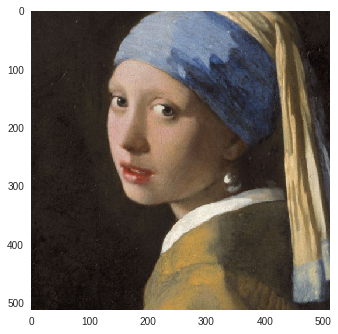

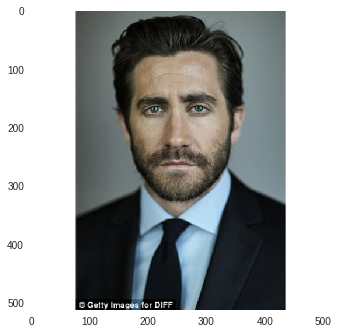

In [52]:
ver=imload("vermeer1.jpg", imsize,False).to(device)
imshow(ver)
imshow(jake)

step: 0 / 32
step: 4 / 32
step: 8 / 32
step: 12 / 32
step: 16 / 32
step: 20 / 32
step: 24 / 32
step: 28 / 32
32 steps complete


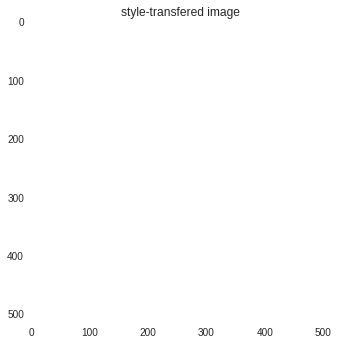

tensor([[[[1., 1., 1.,  ..., 1., 1., 1.],
          [1., 1., 1.,  ..., 1., 1., 1.],
          [1., 1., 1.,  ..., 1., 1., 1.],
          ...,
          [1., 1., 1.,  ..., 1., 1., 1.],
          [1., 1., 1.,  ..., 1., 1., 1.],
          [1., 1., 1.,  ..., 1., 1., 1.]],

         [[1., 1., 1.,  ..., 1., 1., 1.],
          [1., 1., 1.,  ..., 1., 1., 1.],
          [1., 1., 1.,  ..., 1., 1., 1.],
          ...,
          [1., 1., 1.,  ..., 1., 1., 1.],
          [1., 1., 1.,  ..., 1., 1., 1.],
          [1., 1., 1.,  ..., 1., 1., 1.]],

         [[1., 1., 1.,  ..., 1., 1., 1.],
          [1., 1., 1.,  ..., 1., 1., 1.],
          [1., 1., 1.,  ..., 1., 1., 1.],
          ...,
          [1., 1., 1.,  ..., 1., 1., 1.],
          [1., 1., 1.,  ..., 1., 1., 1.],
          [1., 1., 1.,  ..., 1., 1., 1.]]]], device='cuda:0',
       requires_grad=True)

In [53]:
transfer(ver,jake)

step: 0 / 8


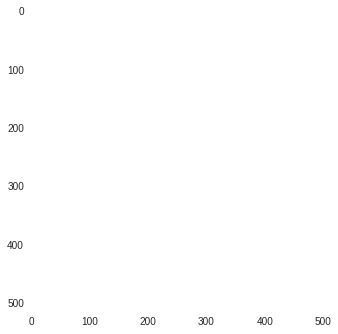

step: 1 / 8


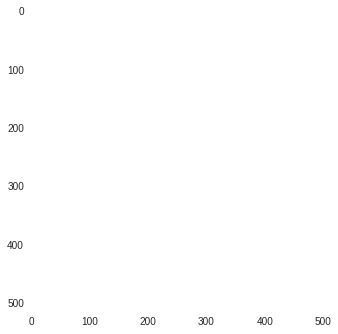

step: 2 / 8


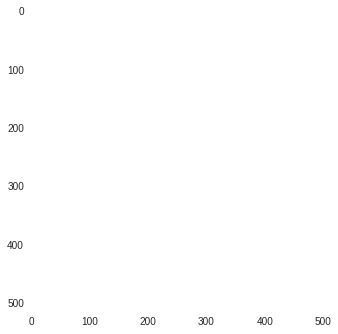

step: 3 / 8


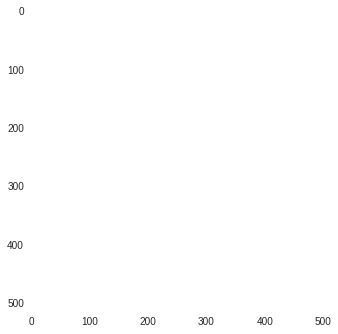

step: 4 / 8


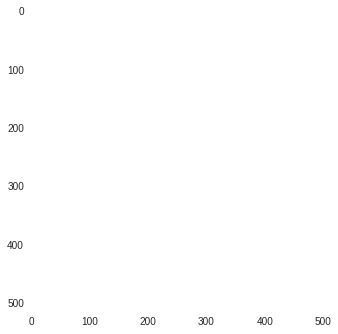

step: 5 / 8


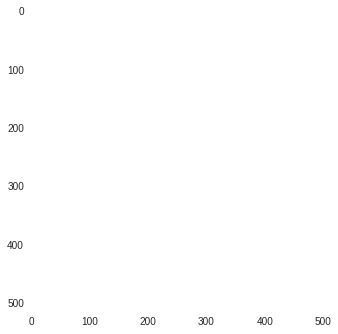

step: 6 / 8


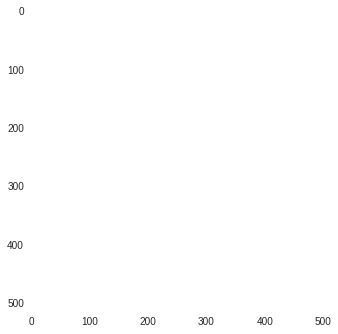

step: 7 / 8


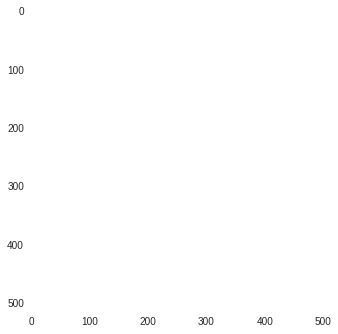

8 steps complete


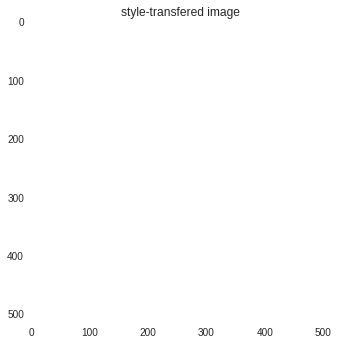

tensor([[[[1., 1., 1.,  ..., 1., 1., 1.],
          [1., 1., 1.,  ..., 1., 1., 1.],
          [1., 1., 1.,  ..., 1., 1., 1.],
          ...,
          [1., 1., 1.,  ..., 1., 1., 1.],
          [1., 1., 1.,  ..., 1., 1., 1.],
          [1., 1., 1.,  ..., 1., 1., 1.]],

         [[1., 1., 1.,  ..., 1., 1., 1.],
          [1., 1., 1.,  ..., 1., 1., 1.],
          [1., 1., 1.,  ..., 1., 1., 1.],
          ...,
          [1., 1., 1.,  ..., 1., 1., 1.],
          [1., 1., 1.,  ..., 1., 1., 1.],
          [1., 1., 1.,  ..., 1., 1., 1.]],

         [[1., 1., 1.,  ..., 1., 1., 1.],
          [1., 1., 1.,  ..., 1., 1., 1.],
          [1., 1., 1.,  ..., 1., 1., 1.],
          ...,
          [1., 1., 1.,  ..., 1., 1., 1.],
          [1., 1., 1.,  ..., 1., 1., 1.],
          [1., 1., 1.,  ..., 1., 1., 1.]]]], device='cuda:0',
       requires_grad=True)

In [55]:
transferMultiStyle([ver],jake,steps=8)